# Convergence Analysis

In [42]:
import pandas as pd
import numpy as np
import os as os

nu = 0.1
R = 0.5
# in the simulations, the length of the channel (W) is adjusted such that G= deltaP/W = 1
G = 1  
t_scale = R**2/nu
l_scale = R
v_scale = G*R**2/(2*nu)

figPath = os.path.join(os.getcwd(),'figures')
studyPath = os.path.join(os.getcwd(), '../../','navierNonEqSlipPoiseuille')

if not os.path.exists(studyPath):
    print(f'The path where the study data should be located is:\n\n\t{studyPath}\n')
    print('You may need to unpack the OpenFOAM simulation data:')
    print('\n\t\t tar -zxvf navierNonEqSlipPoiseuille.tar.gz')

## Loading Data

In [43]:
import os
import numpy as np
import pandas as pd

def time_format(t):
    '''Time format for files in case/evaluation folders.

    Returns for example 1, 1.5, 2, 2.5, ...
    '''
    if t % 1 == 0:
        return '{:d}'.format(int(t))
    else:
        return '{:1}'.format(t)
    return


def read_case(eval_path):
    '''Reads all velocity fields in eval_path/velocities_*.dat'''

    velocity_files = filter(
        lambda string: 'velocities_' in string, os.listdir(eval_path))
    times_str = map(lambda name: name.replace(
        'velocities_', '').replace('.dat', ''), velocity_files)
    times = sorted([float(time) for time in times_str])
    sorted_files = ['velocities_' + time_format(t) + '.dat' for t in times]

    case_data = {}
    for t, file_name in zip(times, sorted_files):
        csv_path = os.path.join(eval_path,file_name)
        df = pd.read_csv(csv_path, sep='\t')
        case_data[t] = df[['y', 'vx']]
    return case_data

def read_mesh_study(path):
    dirs = os.listdir(path)
    dirs = filter(lambda d: 'Ny' in d, dirs)
    data = {}
    for case_path in dirs:
        full_case_path = os.path.join(path, case_path)
        ny = int(case_path.replace('Ny', ''))
        data[ny] = read_case(f'{full_case_path}/evaluation')
    return data

pot_dirs = os.listdir(studyPath)
slip_dirs = filter(lambda d: 'slipLength' in d, pot_dirs)

# only parts of the folder name that look like Lp0.01_Lm1.0
db = {}
for d in slip_dirs:
    # read mesh study
    substr = d.replace('slipLength', '')
    Lp = substr.split('_')[0].replace('Lp','')
    Lm = substr.split('_')[1].replace('Lm','')
    print("Processing: Lp: " + str(float(Lp)) + ' Lm: ' + str(float(Lm)))
    
    path = os.path.join(studyPath,d)
    if float(Lp) not in db:
        db[float(Lp)] = {}
    db[float(Lp)][float(Lm)] =  read_mesh_study(path)
print("Loading completed.")

Processing: Lp: 0.01 Lm: 0.01
Processing: Lp: 0.0001 Lm: 0.0001
Loading completed.


## Available keys

In [44]:
# available keys
Lp = list(db.keys())
Lm = list(list(db[next(iter(db.keys()))].keys()))
print("Lp: " + str(Lp))
print("Lm: " + str(Lm))

Lp: [0.01, 0.0001]
Lm: [0.01]


## Sample data

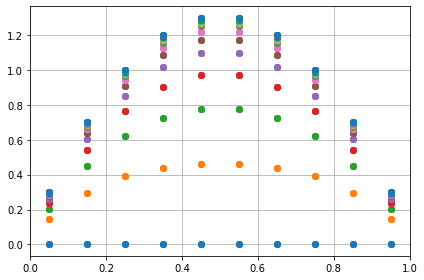

In [45]:
import matplotlib.pyplot as plt

Lp = 0.01 ## change to 1.0 for plot in paper
Lm = 0.01
Ny = 10

fig, ax = plt.subplots(1, 1)
fig.set_tight_layout(True)

for t in db[Lp][Lm][Ny]:
    y = db[Lp][Lm][Ny][t]['y']
    vx = db[Lp][Lm][Ny][t]['vx']
    ax.plot(y, vx, marker='o', ls='', label='t='+str(t))
    
ax.set_xlim([0,1.0])
ax.grid()

## Scale length and velocity

In [46]:
from theoretical.analytical.channel import channelFlows as cf

N = 10
y_ana_scaled = np.linspace(-1.0, 1.0, 100)

def trans_l(y, l_scale):
    return (y - 0.5)/l_scale

def trans_v(v, v_scale):
    '''Transform and scale the velocity field'''
    # v_scale = G*R**2/(2*nu)
    return v/v_scale

def trans_t(t, t_scale):
    return t/t_scale

# scale as in the cell for the plot
db_scaled = {}
    
for lp in db.keys():
    sp = lp/R
    if float(sp) not in db_scaled:
        db_scaled[float(sp)] = {}
    for lm in db[lp].keys():
        sm = lm/R
        if float(sm) not in db_scaled.keys():
            db_scaled[float(sp)][float(sm)] = {}
        print('Scaling: ' + 'sp: ' + str(sp) + ' sm: ' + str(sm))
        db_scaled[float(sp)][float(sm)] = {}
        for ny in db[lp][lm].keys():
            db_scaled[sp][sm][ny] = {}
            for t, case_t in db[lp][lm][ny].items():
                db_scaled[sp][sm][ny][t] = {}

                y_num = case_t['y']
                vx_num = case_t['vx']

                y_num_scaled = trans_l(y_num, l_scale)
                vx_num_scaled = trans_v(vx_num, v_scale)
                vx_ana_scaled = cf.navierSlip_scaled(
                    trans_t(t, t_scale), y_ana_scaled, sp, sm, N)
                
                y_ref_scaled = y_num_scaled
                vx_ref_scaled = cf.navierSlip_scaled(
                    trans_t(t, t_scale), y_ref_scaled, sp, sm, N)

                db_scaled[sp][sm][ny][t] = {}
                db_scaled[sp][sm][ny][t]['y_num'] = y_num_scaled
                db_scaled[sp][sm][ny][t]['vx_num'] = vx_num_scaled
                db_scaled[sp][sm][ny][t]['y_ana'] = y_ana_scaled
                db_scaled[sp][sm][ny][t]['vx_ana'] = vx_ana_scaled
                
                db_scaled[sp][sm][ny][t]['y_ref'] = y_num_scaled
                db_scaled[sp][sm][ny][t]['vx_ref'] = vx_ref_scaled

print("Scaling completed.")

Scaling: sp: 0.02 sm: 0.02
Scaling: sp: 0.0002 sm: 0.0002
Scaling completed.


## Scaled plot

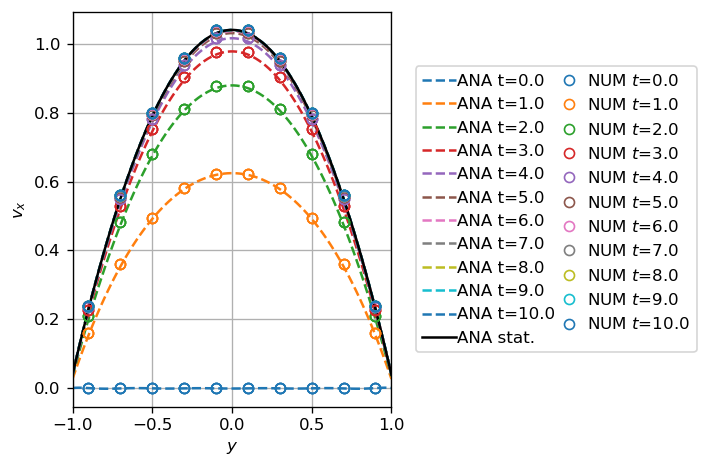

In [47]:
import matplotlib.pyplot as plt

sp = 0.02 #change to 2.0 for plot in paper
sm = 0.02
Ny = 10

fig, ax = plt.subplots(1, 1)
fig.set_dpi(120)
fig.set_tight_layout(True)
t, case_t = next(iter(db_scaled[sp][sm][Ny].items()))
y_ana = case_t['y_ana']

colors = []
for t, case_t in db_scaled[sp][sm][Ny].items():
    if t % 1:
        continue
    y_ana = case_t['y_ana']
    vx_ana = case_t['vx_ana']
    line, = ax.plot(y_ana, vx_ana, ls='--',  label='ANA t='+str(t))
    colors.append(line.get_color())
    
ax.plot(y_ana, cf.poiseuille_scaled(y_ana, sp, sm), color='black', label='ANA stat.')
ax.set_xlabel('$y$')
ax.set_ylabel('$v_x$')

c=0
for t, case_t in db_scaled[sp][sm][Ny].items():
    if t % 1:
        c+=1
        continue
    y_num = case_t['y_num']
    vx_num = case_t['vx_num']
    line, = ax.plot(y_num, vx_num, \
            marker='o', markerfacecolor='None', color=colors[c], markersize=6, ls='', label='NUM $t$='+str(t))
    
ax.set_xlim([-1.0,1.0])
ax.grid()
ax.legend(loc='center left', bbox_to_anchor=[1.05,0.5], ncol=2, columnspacing=-0.2, handletextpad=0.1);

fig.savefig(figPath + "/vel_ana_num_" + str(sp) + '_' + str(sm) + ".pdf")

# Figure 6

plotting left $t$=0.0
plotting left $t$=1.0
plotting left $t$=2.0
plotting left $t$=3.0
plotting left $t$=4.0
plotting left $t$=5.0
plotting left $t$=6.0
plotting left $t$=7.0
plotting left $t$=8.0
plotting left $t$=9.0
plotting left $t$=10.0


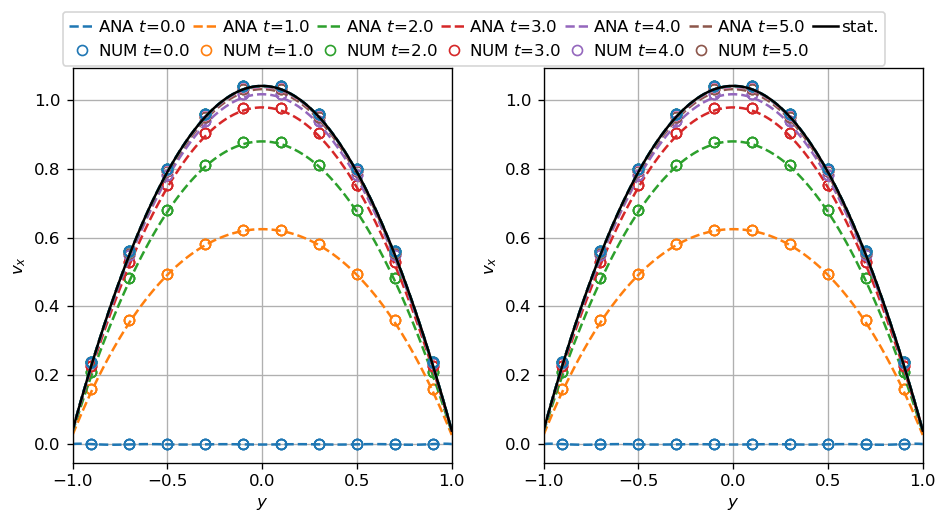

In [48]:
fig, ax = plt.subplots(1, 2)
fig.set_dpi(120)
fig.set_tight_layout(True)
fig.set_size_inches(8.0, 4.0)

sp = 0.02 # change to 2.0 for plot in paper
sm = 0.02
Ny = 10

colors = []
t, case_t = next(iter(db_scaled[sp][sm][Ny].items()))
y_ana = case_t['y_ana']
for t, case_t in db_scaled[sp][sm][Ny].items():
    if t % 1:
        continue
    print('plotting left $t$=' + str(t))
    # analytic solution
    y_ana = case_t['y_ana']
    vx_ana = case_t['vx_ana']
    line, = ax[0].plot(y_ana, vx_ana, ls='--')
        
    # numeric solution 
    y_num = case_t['y_num']
    vx_num = case_t['vx_num']
    line, = ax[0].plot(y_num, vx_num, \
            marker='o', markerfacecolor='None', \
            color=line.get_color(), markersize=6, ls='')
    
# stationary solution    
ax[0].plot(y_ana, cf.poiseuille_scaled(y_ana, sp, sm), color='black')
ax[0].grid()
ax[0].set_xlabel('$y$')
ax[0].set_ylabel('$v_x$')
ax[0].set_xlim(y_ana[0], y_ana[-1])
    
sp = 0.02 # change to 2.0 for plot in paper
sm = 0.02 # change to 2.0 for plot in paper
Ny = 10
colors = []
t, case_t = next(iter(db_scaled[sp][sm][Ny].items()))
y_ana = case_t['y_ana']
for t, case_t in db_scaled[sp][sm][Ny].items():
    
    if t>30:
        break
    if t % 1:
        continue
        
    # analytic solution
    y_ana = case_t['y_ana']
    vx_ana = case_t['vx_ana']
    if t <= 5.0:
        line, = ax[1].plot(y_ana, vx_ana, ls='--',  label='ANA $t$='+str(t))
    else: 
        line, = ax[1].plot(y_ana, vx_ana, ls='--')
        
    # numeric solution 
    y_num = case_t['y_num']
    vx_num = case_t['vx_num']
    if t <= 5.0:
        line, = ax[1].plot(y_num, vx_num, \
                marker='o', markerfacecolor='None', color=line.get_color(), \
                markersize=6, ls='', label='NUM $t$='+str(t))
    else: 
        line, = ax[1].plot(y_num, vx_num, \
                marker='o', markerfacecolor='None', color=line.get_color(), \
                markersize=6, ls='')
        
# stationary solution    
ax[1].plot(y_ana, cf.poiseuille_scaled(y_ana, sp, sm), ls='-', color='black', label='stat.')
ax[1].grid()
ax[1].set_xlabel('$y$')
ax[1].set_ylabel('$v_x$')
ax[1].set_xlim(y_ana[0], y_ana[-1])

lgd = fig.legend(loc='lower center', bbox_to_anchor=(0.5, 0.95), ncol=7, handletextpad=0.2, columnspacing=0.2, handlelength=1.5)
fig.tight_layout()
fig.savefig(figPath + '/startUpFlowSlip_' + str(sp) + '_' + str(sm) + '.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')

## Compute max-norms for mesh convergence

In [49]:
from theoretical.analytical.channel import channelFlows as cf

def norm(x):
    return max(abs(x))

norms = {}
for sp in db_scaled.keys():
    norms[sp] = {}
    for sm in db_scaled[sp].keys():
        norms[sp][sm] = {}
        for ny in db_scaled[sp][sm].keys():
            norms[sp][sm][ny] = {}
            for t, case_t in db_scaled[sp][sm][ny].items():
                vx_num_scaled = np.array(case_t['vx_num'])
                vx_ref_scaled = np.array(case_t['vx_ref'])
                norms[sp][sm][ny][t] = norm(vx_ref_scaled - vx_num_scaled)

print("Computation of norms done.")

Computation of norms done.


## Reorganize to access norms[sp][sm][t][ny] instead of norms[sp][sm][ny][t]

In [50]:
# reorganize the norms
# create db_norms structure
db_norms = {}
for sp in norms.keys():
    db_norms[sp] = {}
    for sm in norms[sp].keys():
        db_norms[sp][sm] = {}
        for ny in norms[sp][sm].keys():
            for t in norms[sp][sm][ny].keys():
                db_norms[sp][sm][t] = {}
            
for sp in norms.keys():
    for sm in norms[sp].keys():
        for ny in norms[sp][sm].keys():
            for t in norms[sp][sm][ny].keys():
                db_norms[sp][sm][t][ny] = norms[sp][sm][ny][t]
print("Reorganization of norms complete.")

Reorganization of norms complete.


## Plot Error norms

For higher value of $S_+$ and $S_-$ the slip increases and so does the time to reach the stationary
state in the corresponding CFD simulation. Decreasing the time step gave the convergence plot visible 
here. To obtain the correct convergence results for the highest resolutions with a further decrease in time
step leads to unacceptable simulation times and has been omitted. The effect however has been clearly
observed for the lower resolved meshes and is sufficient to verify the algorithm for the start-up solution 
and are shown here.

# Figure 7

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1)
fig.set_tight_layout(True)
fig.set_dpi(120)

# test values
sp = 0.02 # change to 0.0002 for plot in paper
sm = 0.02

Sp_keys = list(sorted(norms.keys()))
Sm_keys = list(sorted(norms[next(iter(db_norms.keys()))]))
time_keys = list(norms[Sp_keys[0]][Sm_keys[0]][ny].keys())

print('Available slip lengths: ' \
        + '\nSp: ' + str(Sp_keys) \
        + '\nSm: ' + str(Sm_keys))
print('Available times:\n' + str(time_keys))

import math
for t in time_keys:
    if t>5.0:
        break
    if math.isclose(t, 0.0):
        continue
    data = {'ny' : list(db_norms[sp][sm][t].keys()), 'maxNorm' : list(db_norms[sp][sm][t].values())}
    df = pd.DataFrame(data)
    df.sort_values(by=['ny'], inplace=True)
    ax.loglog( \
          df['ny'][:-2], df['maxNorm'][:-2], \
          marker='o', ls='-', label='$t$ = ' + str(t))

# plot reference 2nd order curve
nys = np.array(sorted(list(db_norms[sp][sm][t].keys()-{5,160,320,640,1280})))
order2 = 2.0*np.power(nys,-2.0)
ax.loglog(nys, order2, ls='--', color='black', label='2nd order')


# Suppress minor tick labels
major_xticks = list(sorted(list(db_norms[sp][sm][t].keys()-{320})))
ax.set_xticks(major_xticks);
ax.set_xticks([], minor = True);
ax.set_xticklabels(list(sorted(major_xticks)))

ax.grid('on')
ax.set_xlabel('Ny')
ax.set_ylabel('$|| e ||_{\infty}$')
ax.legend(loc='lower left', ncol=1,labelspacing=.3);

#fig.savefig(figPath + "/convergence_" + str(sp) + '_' + str(sm) + ".pdf")